In [8]:
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from textblob import TextBlob
from textblob_nl import PatternTagger, PatternAnalyzer
from matplotlib.ticker import MultipleLocator
from datetime import datetime
from loguru import logger
import matplotlib.dates as mdates
import click
from matplotlib.ticker import MultipleLocator
from statsmodels.nonparametric.smoothers_lowess import lowess

In [9]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
config

{'raw': 'data/raw',
 'processed': 'data/processed',
 'input': '_chat.txt',
 'current': 'whatsapp-20250910-235500.parquet',
 'inputpath': 'your-path-here.csv',
 'datetime_format': '%d/%m/%Y, %H:%M:%S',
 'drop_authors': [],
 'logging': {'logdir': 'logs'}}

In [10]:
# Remove default logger and add console sink
logger.remove()
logger.add(sys.stderr, level="INFO")

# Get log directory from config
log_dir = Path(config["logging"]["logdir"]).resolve()
log_dir.mkdir(parents=True, exist_ok=True)  # ensure folder exists

# Build timestamped logfile path
# timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
# logfile = log_dir / f"logfile-{timestamp}.log"

logfile = log_dir / f"logfile.log"

# Add file sink
logger.add(
    logfile,
    rotation="10 MB",
    retention="30 days",
    compression="zip",
    level="DEBUG",
    enqueue=True
)

4

In [11]:
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

In [12]:
df = pd.read_parquet(datafile)

In [13]:
# --- Step 1: Compute sentiment per message for all keywords, using NL analyzer/tagger ---
def compute_keyword_sentiment_nl(df, keywords):
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    # Gebruik TextBlob-NL voor sentiment
    def sentiment_nl(text: str):
        blob = TextBlob(str(text), pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
        # TextBlobNL geeft blob.sentiment als een tuple (polarity, subjectivity)
        return blob.sentiment[0]  # pak polarity

    df["sentiment"] = df["message"].apply(sentiment_nl)

    for kw in keywords:
        # per bericht: of het keyword voorkomt → zo ja: sentiment, anders NaN
        df[kw] = df["message"].apply(
            lambda m: sentiment_nl(m) if kw.lower() in str(m).lower() else np.nan
        )

    return df[["timestamp", "message"] + keywords + ["sentiment"]]


# --- Step 2: Resample monthly to get mean sentiment per keyword ---
def resample_monthly_sentiment(df_keywords, keywords):
    df_keywords = df_keywords.set_index("timestamp")
    # For each keyword column calculate the monthly mean sentiment
    monthly_sentiment = df_keywords[keywords].resample("ME").mean()
    return monthly_sentiment


# --- Step 3: Filter months where all keywords appear (geen NaN voor deze maanden) ---
def filter_cooccurring_months(monthly_sentiment, keywords):
    filtered = monthly_sentiment.dropna(subset=keywords)
    return filtered


# --- Step 4: Get the actual messages where *alle* keywords co-occur in dezelfde message ---
def get_cooccurring_messages(df, keywords):
    mask = df[keywords].notna().all(axis=1)
    df_cooccur = df.loc[mask, ["timestamp", "message", "sentiment"]].copy()
    return df_cooccur


# --- Plot: trends + highlight cooccurrence maanden ---
def plot_cooccurring_keywords_with_highlights(monthly_sentiment, cooccurring_messages, keywords):
    plt.figure(figsize=(12, 6))
    all_trends = []

    # Ensure tz-naive
    monthly_sentiment.index = monthly_sentiment.index.tz_localize(None)
    cooccurring_messages["timestamp"] = cooccurring_messages["timestamp"].dt.tz_localize(None)

    # Plot smoothed sentiment trends
    for kw in keywords:
        series = monthly_sentiment[kw].dropna()

        # rolling mean (3 months window)
        smoothed = series.rolling(window=3, min_periods=1, center=True).mean()

        # lowess smoothing (optional)
        lowess_fit = lowess(
            series.values,
            series.index.astype(np.int64),
            frac=0.4,
            return_sorted=False
        )

        # plot original points
        #plt.plot(series.index, series.values, "o", alpha=0.4, label=f"{kw} (raw)")

        # plot rolling mean
        plt.plot(smoothed.index, smoothed.values, "-", linewidth=2, label=f"{kw} (rolling mean)")

        # plot LOWESS smoothed
        #plt.plot(series.index, lowess_fit, "--", linewidth=2, label=f"{kw} (LOWESS smooth)")

        all_trends.append(series)

    # General trend (regression)
    general_trend = pd.concat(all_trends, axis=1).mean(axis=1).dropna()
    if not general_trend.empty:
        x = np.arange(len(general_trend))
        coeffs = np.polyfit(x, general_trend.values, 1)
        y_fit = np.polyval(coeffs, x)
        plt.plot(general_trend.index, y_fit, color="red", linestyle="--", linewidth=2, label="Algemene trend (regressie)")

    # Highlight months with co-occurrences
    cooccurring_month_ends = cooccurring_messages["timestamp"].dt.to_period("M").dt.to_timestamp("M")
    cooccurring_month_ends = cooccurring_month_ends.dt.tz_localize(None)

    for kw in keywords:
        x_vals, y_vals = [], []
        for m in cooccurring_month_ends:
            if m in monthly_sentiment.index:
                x_vals.append(m)
                y_vals.append(monthly_sentiment.loc[m, kw])
        plt.scatter(x_vals, y_vals, color="black", s=120, zorder=5, marker="*", label=f"Maand met co-'{kw}'")

    # X-axis ticks
    all_ticks = sorted(set(monthly_sentiment.index).union(set(cooccurring_month_ends)))
    plt.xticks(all_ticks, rotation=45)

    # Formatting
    plt.axhline(y=0, color="gray", linestyle="--", label="Neutraal sentiment")
    plt.xlabel("Datum")
    plt.ylabel("Gemiddeld sentiment (-1 negatief, +1 positief)")
    plt.title(f"Sentiment trends voor keywords: {', '.join(keywords)} (met smoothing en co-occurrences)")
    plt.legend()
    ax = plt.gca()
    ax.yaxis.set_major_locator(MultipleLocator(0.02))
    plt.tight_layout()
    plt.show()


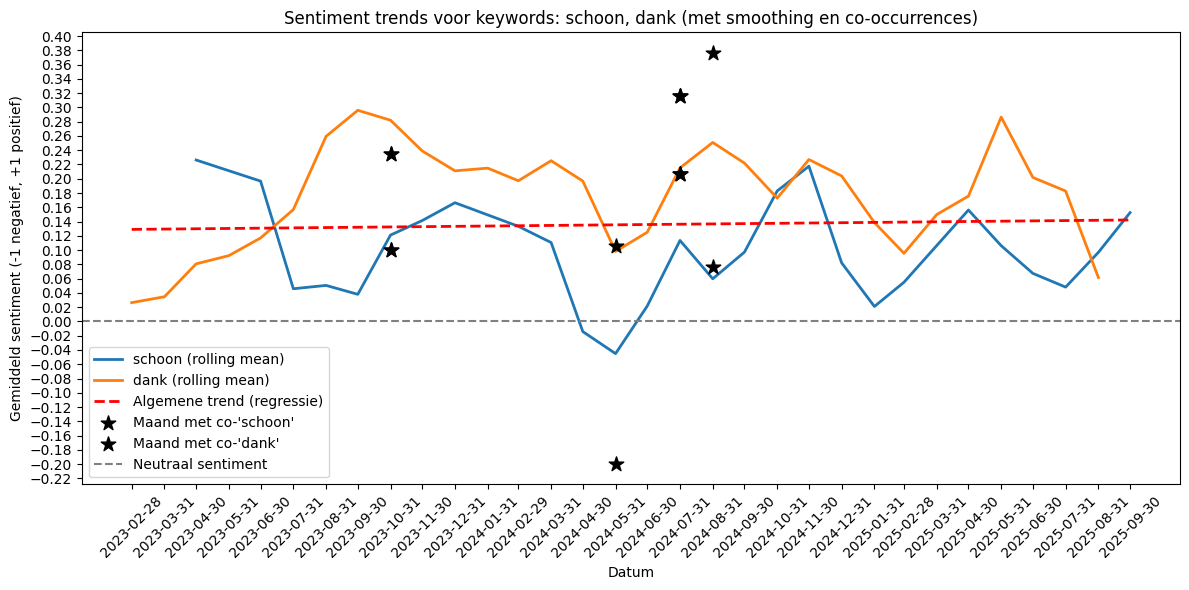

Co-occurring messages:
               timestamp                                            message  \
728  2023-10-02 20:48:12  Veel dank voor schoonmaken betonspetters! Het ...   
767  2023-10-07 18:21:29    Dankjewel Joan, dat jij het hebt schoongemaakt.   
1610 2024-05-10 11:16:40                    Bedankt voor de schoonmaak Henk   
2096 2024-07-05 10:57:46  Hi Martin, dat zijn onze stukadoors geweest. E...   
2145 2024-07-17 17:44:58  Vandaag de box gedeeltijk schoongemaakt,ook bi...   
2260 2024-07-26 12:05:35  De vloeren van de berging zien er weer tip top...   
2324 2024-08-06 12:08:04  Dank allemaal voor jullie geduld en begrip! Na...   

      sentiment  
728    0.400000  
767    0.000000  
1610   0.000000  
2096   0.455556  
2145   0.577083  
2260   0.679167  
2324   0.072917  


In [14]:
# --- Voorbeeldgebruik ---
keywords = ["schoon", "dank"]
df_keywords = compute_keyword_sentiment_nl(df, keywords)
monthly_sentiment = resample_monthly_sentiment(df_keywords, keywords)
cooccurring_months = filter_cooccurring_months(monthly_sentiment, keywords)
cooccurring_messages = get_cooccurring_messages(df_keywords, keywords)

plot_cooccurring_keywords_with_highlights(monthly_sentiment, cooccurring_messages, keywords)

print("Co-occurring messages:")
print(cooccurring_messages)